# RoadRunner transit model

*Author: Hannu Parviainen* <br/>
*Last edited: 23 April 2024*

The RoadRunner transit model [Parviainen (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.2752P/abstract) can reproduce an exoplanet transit signal for any radially symmetric stellar limb darkening with high precision, and generally does this faster than the analytic model for quadratic limb darkening by [Mandel & Agol (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...580L.171M/abstract). The model also provides partial derivatives with respect to the impact parameter and radius ratio with very little overhead. 

This notebook explains how and what RoadRunner does to achieve the combined speed and flexibility. 

**Summary for those who don't bother to read all the following:** The RoadRunner model represents the transit as a product of an average limb darkening occluded by the planet and planet-star intersection area. The former can be calculated as a weighted sum of the discretised limb darkening profile, and the latter is fast to calculate analytically. The weights need to be computed for a given radius ratio, but this takes only some $\mu$s of computing time after which the model evaluation for a single point takes some hundreds of ns.

**Even shorter summary:** The RoadRunner model represents the transit as a product of the uniform limb darkening transit model and a one-variable function. Because of this, its partial derivatives with respect with radius ratio and impact parameter can also be calculated as slightly modified versions of those for the uniform limb darkening transit model, but for any radially symmetric limb darkening profile imagineable.

**Warning:** This notebook shows the low-level working of the RoadRunner model. For actual transit modelling, you will most likely just want to do

    from pytransit import RoadRunnerModel

and let the higher-level code take care of all the dirty work.


## The basics
### Transit signal

An exoplanet transit model aims to reproduce the photometric signal caused by a planet crossing over the disk of its host star. The flux normalised to the out-of-transit level is

$$
F = \frac{I_\star - I_\mathrm{p}}{I_\star},
$$

where $I_\star$ is the total flux from the star, 

$$
I_\star = \int_{A_\star} I(z)\; \mathrm{d}A,
$$

$I_\mathrm{p}$ is the flux occluded by the planet,

$$
I_\mathrm{p} = \int_{A_\mathrm{p}} I(z)\; \mathrm{d}A,
$$

$A_\star$ stands for the area of the star, $A_\mathrm{p}$ stands for the area of the stellar surface occluded by the planet, and $I(z)$ is the stellar surface brightness as a function of the distance from the stellar centre, $z$.

### The RoadRunner model

The main idea behind the RoadRunner transit model is simple: the integral of the stellar surface brightness occluded by the planet can be presented as a product of the mean occluded surface brightness and occluded area. When the stellar surface brightness is given by a radially symmetric limb darkening model, $I(\mu)$, where $\mu = \sqrt{1-z^2}$ and $z$ is the distance from the centre of the stellar disk (normalised to stellar radius), *the flux blocked by the planet is simply the mean limb darkening value covered by the planet multiplied by the covered area,*

$$
I_\mathrm{p} = \int_{A_\mathrm{p}} I(z)\; \mathrm{d}A = \hat{I} A.
$$

Now, the mean limb darkening covered by a planet, $\hat{I}$, is a function of the limb darkening profile, planet-star radius ratio, $k$, and planet-star centre distance (impact parameter), $b$. Given $k$ and a limb darkening profile, $\hat{I}$ can be presented as a (relatively) smooth function of $b$.

Because of this, **a transit model for a given $k$ and any radially symmetric limb darkening profile can be presented as a product of a one-variable function, $\hat{I}(g)$, where $g = b/(1+k)$ and $0 \leq g \leq 1$,  and circle-circle intersection area**

$$
F = \frac{I_\star - \hat{I}(g) A(k,g)}{I_\star}.
$$

The average surface brightness can be calculated for a given $k$ and $g$ as
$$
\hat{I} = \int_0^1 w(z|g,k) I(z)\; \mathrm{d}z,
$$
where $w$ is a normalised weight function ($\int_0^1 w(z|g,k)\;\mathrm{d}z=1$). If we discretise the stellar disk, $z \in [0, 1]$, to $n_z$ bins, we can present the integral above as a dot product of a weight and limb darkening profile vectors
$$
\hat{I} = \mathbf{w}^T \cdot \mathbf{I}
$$

So, the transit model can be presented as a product of $\hat{I}$ and $A(k, b)$, where $\hat{I}$ is a weighted average of a limb darkening profile. 


### Connection with the transit model for uniform limb darkening

The transit model for uniform stellar limb darkening is

$$
F = \frac{\pi - A(k,g)}{\pi},
$$

so *the RoadRunner model can be seen as a simple extension of the uniform model.* Because of this, its partial derivatives with respect to impact parameter and radius ratio are extremely easy and fast to compute (as shown below). 


## Initialisation


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc('figure', figsize=(13,4))

In [3]:
from pytransit.models.numba.rrmodel import (create_z_grid, 
                                            calculate_weights_2d, calculate_weights_3d, 
                                            circle_circle_intersection_area, circle_circle_intersection_area_v)
from pytransit.models.numba.ldmodels import ld_quadratic, ldi_quadratic

## The weight array

We start by discretising the stellar disk into $n_z$ radial bins from $Z=0$ to $1$. This is done using the ``create_z_grid`` function that returns the bin edges (``ze``) and means (``zm``). We also calculate the $\mu$ values normally used by the limb darkening models.

In [4]:
ze, zm = create_z_grid(0.7, 60, 60)
mu = sqrt(1-zm**2)

Next, we discretise the grazing parameter into $n_g$ bins from $g = 0$ to $1$ and calculate a 2D weight array. This is done using the ``calculate_weights_2d`` that takes the radius ratio, ``k``, the $z$ edges ``ze``, and $n_g$.

In [5]:
k = 0.1
gs, dg, w = calculate_weights_2d(k, ze, 250)
bs = gs * (1+k)

The function returns an array of mean $g$ values, $\Delta g$, and a 2D weight array with a shape ($n_g$, $n_z$)

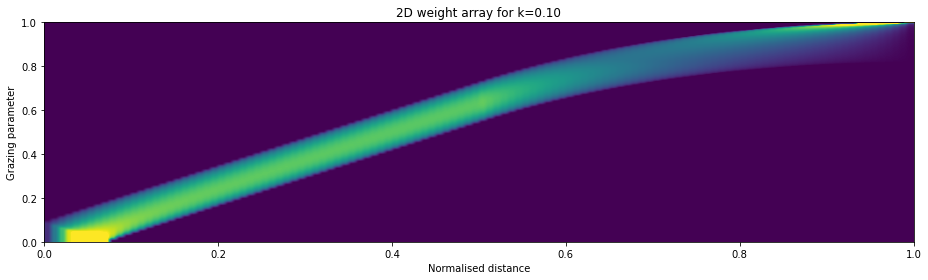

In [6]:
fig, ax = subplots()
ax.imshow(w, vmin=0, vmax=0.1, aspect='auto', extent=(0, 1, 0, 1), origin='lower')
setp(ax, xlabel='Normalised distance', ylabel='Grazing parameter', title=f'2D weight array for k={k:0.2f}')
fig.tight_layout()

## The average limb darkening occluded by the planet

The calculation of the weight array for a given $k$ (shown above) is the most numerically demanding task in the RoadRunner transit model evaluation, and the rest is very fast. 

We continue by evaluating the limb darkening model for the $\mu$ value corresponding to the discretised mean $z$ values.

In [7]:
ldp = ld_quadratic(mu, array([0.53, 0.30]))

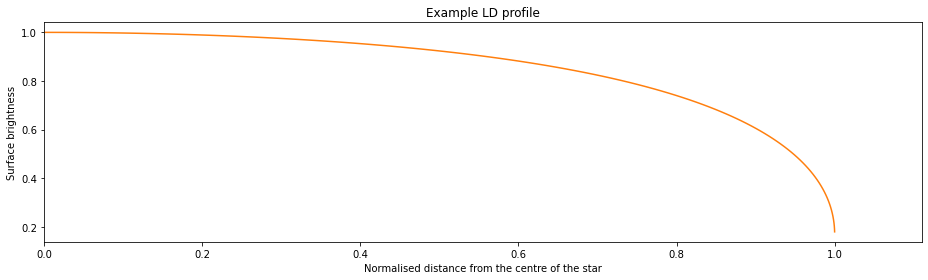

In [8]:
fig, ax = subplots()
ax.plot(zm, ldp, c='C1')
setp(ax, xlabel='Normalised distance from the centre of the star', ylabel='Surface brightness', 
     title='Example LD profile', xlim=(0, 1+1.1*k))
fig.tight_layout()

And then calculate the average limb darkening as a function of $g$ as a dot product of the 2D weight array and the limb darkening profile

In [9]:
lda = dot(w, ldp)

The averaged limb darkening, $\hat{I}$, is now a (discretised) function of the grazing parameter. It is smooth from $g=0$ to $g=(1-k)/(1+k)$, and again from $g=(1-k)/(1+k)$ to $g=1$, but its first derivative has a discontinuity at $g=(1-k)/(1+k)$, that is, $b=1-k$.

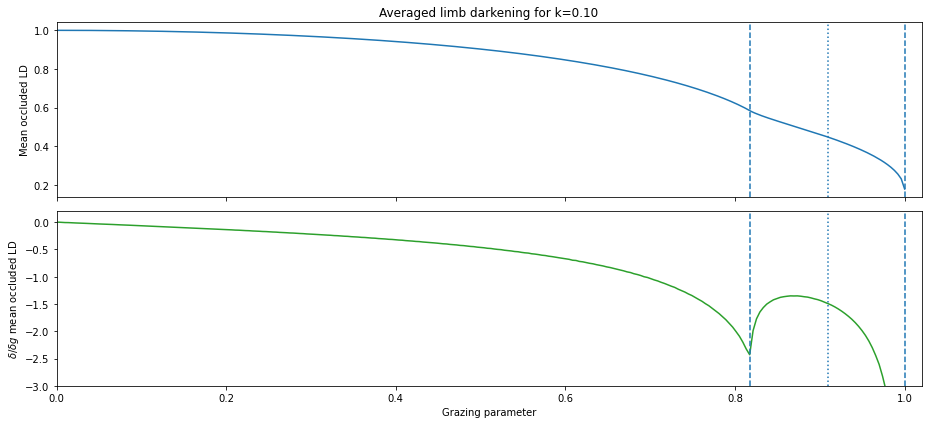

In [10]:
fig, axs = subplots(2, 1, figsize=(13,6), sharex='all')
axs[0].plot(gs, lda, c='C0')
axs[1].plot(0.5*(gs[1:]+gs[:-1]), diff(lda)/dg, c='C2')
[[ax.axvline((1+s*k)/(1+k), ls=ls) for s,ls in zip([-1, 0, 1], ['--', ':', '--'])] for ax in axs]
setp(axs, xlim=(0, 1.02))
setp(axs[0], ylabel='Mean occluded LD', title=f'Averaged limb darkening for k={k:0.2f}')
setp(axs[1], ylabel='$\delta/\delta g$ mean occluded LD', ylim=(-3.0, 0.2), xlabel='Grazing parameter')
fig.tight_layout()

## The transit signal

Now we are nearly ready to evaluate the transit model. However, since the transit signal is the integrated stellar surface brightness minus the surface brightness occluded by the planet, we need to first calculate the first term. 

 The integration of the limb darkening model over the stellar disk can usually be done analytically, and if not, is cheap to do numerically. PyTransit implements the integral of the quadratic limb darkening model in ``pytransit.models.numba.ldmodel.ldi_quadratic`` (yes, it's a bit hidden, but these functions are rarely needed outside the RoadRunner model). 

In [11]:
ist = ldi_quadratic(array([0.53, 0.30]))

And now, armed with the total stellar surface brightness and $\hat{I}(g)$ discretised into a grid, we're finally ready to go! The most straight-forward approach to evaluate the transit model is simply to map the given $b$ values to $g$, interpolate the discretised $\hat{I}$ for the $g$ values (I'm showing the example using ``interp``, but do the interpolation manually in the PyTransit implementation), and multiply by the circle-circle intersection area:

In [12]:
b = 0.4
g = b / (1+k)
ipl = interp(g, gs, lda) * circle_circle_intersection_area(1.0, k, b)
flux = (ist - ipl) / ist
flux

0.987692639827011

where we normalise the out-of-transit level to unity.

Now, lets do the same for a set of star-planet centre distances

In [13]:
b = linspace(-1.2, 1.2, 200)
g = b / (1+k)
ipl = interp(abs(g), gs, lda) * circle_circle_intersection_area_v(1.0, k, abs(b))

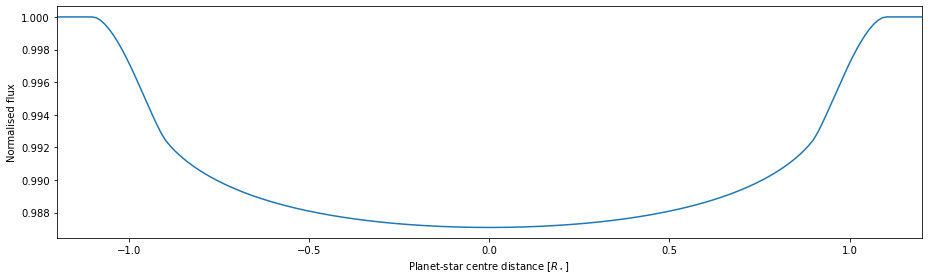

In [14]:
fig, ax = subplots()
ax.plot(b, (ist - ipl) / ist)
setp(ax, xlabel='Planet-star centre distance [$R_\star$]', ylabel='Normalised flux', xlim=(-1.2, 1.2))
fig.tight_layout()

## Derivatives

The full transit model is, again,

$$
F = \frac{I_\star - \hat{I}(k, g) \; A(k, g)}{I_\star},
$$

where $\hat{I}$ is the average limb darkening covered by the planet and $A$ is the planet-star intersection area. So, the transit model is basically the transit model for uniform limb darkening multiplied by the average limb darkening. Because of this, we can get the partial derivatives of the transit model with respect to the grazing parameter (or impact parameter) and radius ratio easily by using the partial derivatives for the uniform model derived in [Agol et al. (AJ, 159, 2020, ALFM from now on)](https://ui.adsabs.harvard.edu/abs/2020AJ....159..123A/abstract).

#### $\delta F / \delta k$:

We get the partial derivative of the flux with respect to the radius ratio using the product rule,

$$
\frac{\delta F}{\delta k} = - \frac{\delta \hat{I}(k, g)}{\delta k} \frac{A(k, g)}{I_\star} - \frac{\delta A(k, g)}{\delta k} \frac{\hat{I}(g)}{I_\star},
$$

where the first term is negligible compared to the second. Because of this, we can make a simplifying assumption that $\delta \hat{I} / \delta k = 0$, after which the derivative is simply the partial derivative of the uniform model with respect to the radius ratio derived in ALFM (Eq. 35) multiplied by the normalised average limb darkening,

$$
\frac{\delta F}{\delta k} = - \frac{\hat{I}}{I_\star} \frac{\delta A}{\delta k} = - 2 k \kappa_0 \frac{\hat{I}}{I_\star},
$$

where $\kappa_0$ is given in Eq. 33 of ALFM, and I've simplified the notation a bit for clarity. The $\kappa_0$ angle is calculated by the accurate circle-circle intersection method also described in ALFM, so we get the partial derivative of the model as a by-product of normal model evaluation without any additional work.

#### $\delta F / \delta b$

The partial derivative of the flux with respect to the impact parameter is

$$
\frac{\delta F}{\delta b} = - \frac{\delta \hat{I}(k, b)}{\delta b} \frac{A(k, b)}{I_\star} - \frac{\delta A(k, b)}{\delta b} \frac{\hat{I}(b)}{I_\star},
$$

were $\delta A / \delta b$ can again be found from ALFM (Eq. 35). Thus, we get

$$
\frac{\delta F}{\delta b} = - \frac{\delta \hat{I}(k, b)}{\delta b} \frac{A(k, b)}{I_\star} - \frac{2 A_\mathrm{kite}}{b} \frac{\hat{I}}{I_\star},
$$

and using numerical $\hat{I}$ differentials calculated from the $\hat{I}$ array, we get

$$
\frac{\delta F}{\delta b} = - \frac{\hat{I}' A}{I_\star} - \frac{2 A_\mathrm{kite}}{b} \frac{\hat{I}}{I_\star},
$$

where $A_\mathrm{kite}$ is given in Eq. 31 of ALFM, and is again calculated by the circle-circle intersection method.

Both partial derivatives are implemented in PyTransit (``pytransit.models.numba.rrmodel.dfdk`` and ``pytransit.models.numba.rrmodel.dfdb``) and their calculation is extremely fast ($\sim500$ ns for a single point). PyTransit is not yet using the derivatives anywhere, but this may likely change in the future.

## Multicolour photometry and transmission spectroscopy

Since the weight array needs to be calculated only once for a given $k$, evaluating the model for multiple passbands with different limb darkening coefficients is fast.

In [15]:
ldcs = [[0.53, 0.30], [0.12, 0.11]]
ldps = [ld_quadratic(mu, array(ldc)) for ldc in ldcs]
ldas = [dot(w, ldp) for ldp in ldps]

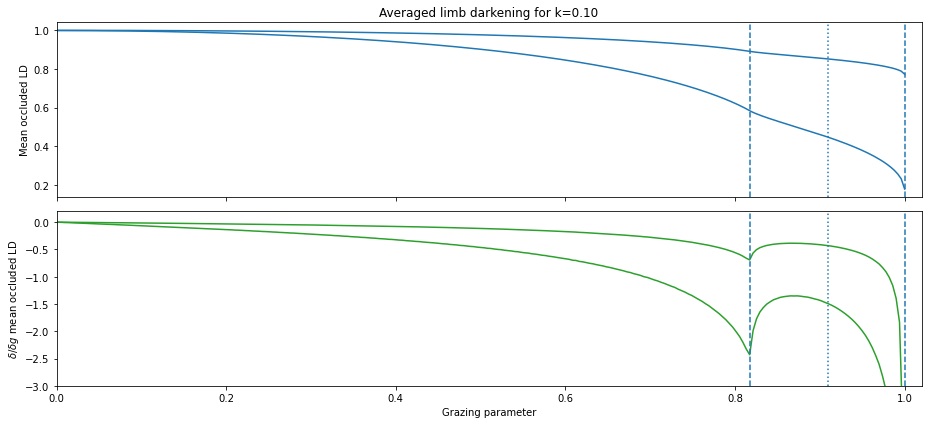

In [16]:
fig, axs = subplots(2, 1, figsize=(13,6), sharex='all')
for lda in ldas:
    axs[0].plot(gs, lda, c='C0')
    axs[1].plot(0.5*(gs[1:]+gs[:-1]), diff(lda)/dg, c='C2')
[[ax.axvline((1+s*k)/(1+k), ls=ls) for s,ls in zip([-1, 0, 1], ['--', ':', '--'])] for ax in axs]
setp(axs, xlim=(0, 1.02))
setp(axs[0], ylabel='Mean occluded LD', title=f'Averaged limb darkening for k={k:0.2f}')
setp(axs[1], ylabel='$\delta/\delta g$ mean occluded LD', ylim=(-3.0, 0.2), xlabel='Grazing parameter')
fig.tight_layout()

If we can assume that the changes in $k$ are small enough that $\hat{I}$ can be considered constant (basically always), we can calculate $\hat{I}$ for the mean $k$ but still calculate the intersection areas using the true $k$ values. 

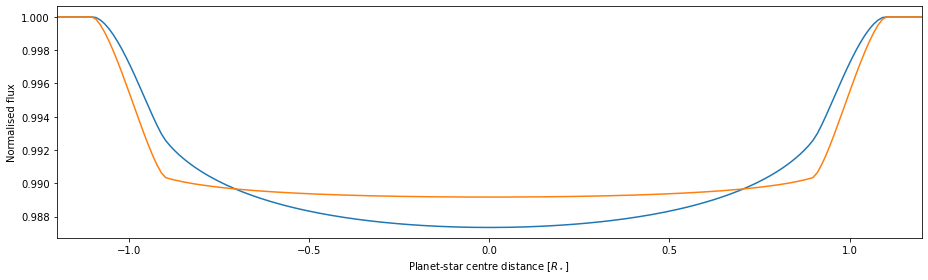

In [17]:
ks = [0.099, 0.101]
ipls = [interp(abs(g), gs, lda) * circle_circle_intersection_area_v(1.0, k, abs(b)) for lda,k in zip(ldas,ks)]
ists = [ldi_quadratic(array(ldc)) for ldc in ldcs]

fig, ax = subplots()
[ax.plot(b, (ist - ipl) / ist) for ist,ipl in zip(ists,ipls)]
setp(ax, xlabel='Planet-star centre distance [$R_\star$]', ylabel='Normalised flux', xlim=(-1.2, 1.2))
fig.tight_layout()

## Future optimisations

The model as it currently stands (PyTransit v1.4) simply discretises $g$ into an uniform grid between 0 and 1. However, both the model accuracy and evaluation speed can probably be improved by making the discretisation smarter.

As the first thing, the grazing parameter space can be divided at $g = (1-k)/(1+k)$. The averaged limb darkening is very smooth before this contact point, so it can either be calculated with a lower $g$ resolution, or possibly even represented as a low-order polynomial. The discretisation could be done with a higher $g$ resolution after the contact point, or maybe mapped so that the areas with larger absolute derivatives are sampled with a higher resolution.

## Acknowledgements

I would like to thank E. Agol for advising me to look into the calculation of the model derivatives.

---

<center>©2024 Hannu Parviainen</center>
